In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning)
wrn.filterwarnings('ignore', category = RuntimeWarning)

In [384]:
train_df = pd.read_csv('D:/숙탯 2기/2022-여름-캐글/9565_hospital_data/train.csv')
test_df = pd.read_csv('D:/숙탯 2기/2022-여름-캐글/9565_hospital_data/test.csv')

# 1. Variable Correction

**label 값 수정 (주어진 조건대로)**

In [385]:
train_df['OC']=train_df['OC'].replace('open',1)
train_df['OC']=train_df['OC'].replace(' close',0)

**날짜 변수를 datetime 타입으로 변경하고 연도, 월 변수 추출**

In [386]:
train_df.openDate = pd.to_datetime(train_df.openDate.astype(str), format='%Y%m%d')
train_df.openDate.head()

0   2007-12-28
1   1997-04-01
2   2016-12-28
3   2000-08-14
4   2005-09-01
Name: openDate, dtype: datetime64[ns]

In [387]:
test_df.openDate = pd.to_datetime(test_df.openDate.astype(str), format='%Y%m%d')
test_df.openDate.head()

0   1998-11-25
1   2016-03-09
2   1989-04-27
3   2010-02-26
4   2004-06-04
Name: openDate, dtype: datetime64[ns]

In [388]:
train_df['Year'] = train_df['openDate'].dt.year
train_df['Month'] = train_df['openDate'].dt.month

test_df['Year'] = test_df['openDate'].dt.year
test_df['Month'] = test_df['openDate'].dt.month

**test data의 employee 인원 변수에서 콤마 삭제 & object에서 수치형으로 변환**

In [389]:
print(test_df.employee1.unique())
print(); print()
print(test_df.employee2.unique())

['693' '379' nan '760' '437' '386' '727' '377' '17' '532' '128' '1,637'
 '1,816' '566' '104' '244' '187' '431' '150' '361' '41' '110' '457' '210'
 '344' '250' '48' '109' '292' '121' '83' '100' '154' '134' '107' '89' '86'
 '69' '93' '324' '1,065' '340' '55' '22' '300' '120' '260' '143' '78' '81'
 '46' '74' '155' '130' '122' '59' '180' '855' '30' '96' '75' '44' '203'
 '70' '129' '67' '85' '236' '29' '116' '37' '25' '45' '47' '52' '56' '76'
 '125' '80' '63' '90' '190' '222' '32' '66' '224' '61' '28' '604' '33'
 '16' '36' '106' '60' '19' '49' '21' '111' '560' '132' '363']


['693' '371' nan '760' '385' '397' '580' '346' '17' '409' '127' '1,547'
 '1,104' '566' '100' '258' '165' '412' '235' '41' '190' '112' '457' '149'
 '280' '260' '52' '109' '292' '121' '85' '82' '42' '55' '95' '96' '72'
 '324' '1,065' '340' '24' '300' '120' '240' '143' '79' '78' '200' '74'
 '49' '150' '125' '108' '117' '59' '191' '855' '30' '37' '188' '0' '70'
 '46' '134' '65' '87' '236' '75' '26' '45' '47' '54' '83' '81' 

- '1,816' 등 콤마를 포함한 문자열로 인원수가 저장되어 있음.

In [390]:
test_df.employee1 = test_df.employee1.str.replace(',', '')
test_df.employee1 = pd.to_numeric(test_df.employee1, errors='ignore')

test_df.employee2 = test_df.employee2.str.replace(',', '')
test_df.employee2 = pd.to_numeric(test_df.employee2, errors='ignore')

**OC, sido, sgg, instkind, owenerChange 범주형 변수로 변환**

In [391]:
cat = ['OC', 'sido', 'sgg', 'instkind', 'ownerChange', 'Month']

for column in cat:
    train_df[column] = train_df[column].astype('category')
    test_df[column] = test_df[column].astype('category')

**변환 결과**

In [392]:
train_df.dtypes.value_counts()

float64           51
int64              2
category           1
category           1
category           1
datetime64[ns]     1
category           1
category           1
category           1
dtype: int64

In [393]:
test_df.dtypes.value_counts()

float64           52
int64              1
category           1
category           1
category           1
datetime64[ns]     1
category           1
category           1
category           1
dtype: int64

# 2. Outlier Treatment

- 데이터셋의 크기가 train data는 301개, test data는 127개로 크지 않으므로 이상치를 제거하지 않도록 한다.

# 3. Handling Missing Values

### 3.1 결측치가 50% 이상인 열 제거

In [394]:
# 열 제거 

train_df = train_df.drop(columns=['receivableL2', 'receivableL1', 'surplus2', 'surplus1'])
test_df = test_df.drop(columns=['receivableL2', 'receivableL1', 'surplus2', 'surplus1'])

### 3.2 Imputation  
### 3.2.1 Numeric Features

- MICE 방법 사용. 선형회귀모델을 기반으로 여러 차례 반복하여 결측값을 도출
- Reference: https://www.numpyninja.com/post/how-to-implement-mice-algorithm-using-iterative-imputer-to-handle-missing-values

In [395]:
train_num = train_df.select_dtypes(exclude = ['category', 'datetime64[ns]'])
test_num = test_df.select_dtypes(exclude = ['category', 'datetime64[ns]'])

train_num.replace(0, np.nan, inplace=True)
test_num.replace(0, np.nan, inplace=True)

In [396]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
MICE_imputer = IterativeImputer(estimator=lr, max_iter=30, verbose=2, tol=1e-5, imputation_order='roman')

train_mice = MICE_imputer.fit_transform(train_num)
test_mice = MICE_imputer.transform(test_num)

[IterativeImputer] Completing matrix with shape (301, 49)
[IterativeImputer] Ending imputation round 1/30, elapsed time 0.49
[IterativeImputer] Change: 630237892845.2562, scaled tolerance: 1640000.0000000002 
[IterativeImputer] Ending imputation round 2/30, elapsed time 0.83
[IterativeImputer] Change: 585516173057.6116, scaled tolerance: 1640000.0000000002 
[IterativeImputer] Ending imputation round 3/30, elapsed time 1.18
[IterativeImputer] Change: 291719216629.4222, scaled tolerance: 1640000.0000000002 
[IterativeImputer] Ending imputation round 4/30, elapsed time 1.53
[IterativeImputer] Change: 101660143312.71304, scaled tolerance: 1640000.0000000002 
[IterativeImputer] Ending imputation round 5/30, elapsed time 1.89
[IterativeImputer] Change: 54108237334.601234, scaled tolerance: 1640000.0000000002 
[IterativeImputer] Ending imputation round 6/30, elapsed time 2.29
[IterativeImputer] Change: 233420771686.984, scaled tolerance: 1640000.0000000002 
[IterativeImputer] Ending imputatio

In [397]:
# imputer로 결측치 대체하면 numpy array가 되므로 다시 데이터프레임으로 변환.

train_mice = pd.DataFrame(train_mice)
train_mice.columns = train_num.columns

test_mice = pd.DataFrame(test_mice)
test_mice.columns = test_num.columns

for col in train_mice.columns:
    train_df[col] = train_mice[col]
    test_df[col] = test_mice[col]     # 변환한 값 덮어쓰기

In [398]:
print(train_df[train_df.bedCount < 0].index)
print(train_df[train_df.employee1 < 0].index)
print(train_df[train_df.employee2 < 0].index)
print()
print(test_df[test_df.bedCount < 0].index)
print(test_df[test_df.employee1 < 0].index)
print(test_df[test_df.employee2 < 0].index)

Int64Index([39, 237, 245], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')

Int64Index([78, 125], dtype='int64')
Int64Index([88], dtype='int64')
Int64Index([], dtype='int64')


In [399]:
# 0으로 변경

train_df.loc[[39, 237, 245], 'bedCount'] = 0
print(train_df[train_df.bedCount < 0].index)

test_df.loc[[78, 125], 'bedCount'] = 0
print(test_df[test_df.bedCount < 0].index)

test_df.loc[88, 'employee1'] = 0
print(test_df[test_df.employee1 < 0].index)

Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')


### 3.2.2 Categorical Features

- KNN 방법 사용
- Datawig 방법 사용하려 했는데 패키지 설치 실패
    + Datawig: DNN(Deep Neural Network)으로 누락된 값을 유추하는 방법.

In [400]:
print(train_df.select_dtypes(include = 'category').isnull().sum())
print()
print(test_df.select_dtypes(include = 'category').isnull().sum())

OC              0
sido            0
sgg             0
instkind        1
ownerChange    12
Month           0
dtype: int64

OC             127
sido             0
sgg              0
instkind         2
ownerChange     15
Month            1
dtype: int64


- test set의 OC 변수는 target 변수이므로 그대로 두어야 함  
- EDA 결과, 명시된 병원종류 ~ 병상 수 관계와 실제 병상 수가 달랐고 두 변수의 상관관계도 높지 않았으므로 bedCount 변수로 instkind 결측치를 추측하는 방안은 버렸음

#### KNNImputer가 작동할 수 있게 숫자로 변환

1) 도시권 구분을 따라 sido 변수 내 범주 병합

In [401]:
change_value_dict = {'seoul':'Seoul', 'gyeonggi':'Seoul', 'incheon':'Seoul',     # 수도권
                    'choongbuk':'Daejeon', 'choongnam':'Daejeon', 'daejeon':'Daejeon', 'sejong':'Daejeon',   # 대전권
                    'gwangju':'Gwangju', 'jeonnam':'Gwangju',    # 광주권
                    'daegu':'Daegu', 'gyeongbuk':'Daegu',     # 대구권
                    'busan':'Busan', 'ulsan':'Busan', 'gyeongnam':'Busan',     # 부산권
                    'gangwon':'etc', 'jeonbuk':'etc', 'jeju':'etc'}    # 기타


train_df['Metro'] = train_df['sido']
test_df['Metro'] = test_df['sido']
train_df = train_df.replace({'Metro':change_value_dict})
test_df = test_df.replace({'Metro':change_value_dict})

In [402]:
train_df['Metro']

0      Daejeon
1        Busan
2        Seoul
3        Seoul
4        Busan
        ...   
296    Gwangju
297    Daejeon
298      Daegu
299      Seoul
300      Seoul
Name: Metro, Length: 301, dtype: category
Categories (6, object): ['Busan', 'Daejeon', 'Daegu', 'etc', 'Gwangju', 'Seoul']

In [403]:
test_df['Metro']

0        Seoul
1          etc
2      Gwangju
3        Busan
4          etc
        ...   
122    Gwangju
123      Seoul
124      Seoul
125        etc
126    Daejeon
Name: Metro, Length: 127, dtype: category
Categories (6, object): ['Busan', 'Daejeon', 'Daegu', 'etc', 'Gwangju', 'Seoul']

- Seoul: 수도권  
- Daejeon: 대전권  
- Gwangju: 광주권  
- Daegu: 대구권  
- Busan: 부산권  
- etc: 기타

In [404]:
# openDate와 sido 변수는 삭제.

train_copy = train_df.copy()    # 나중에 변수 사용할 수도 있으므로 복사해두기
test_copy = test_df.copy()

train_df.drop(['openDate', 'sido'], axis=1, inplace=True)
test_df.drop(['openDate', 'sido'], axis=1, inplace=True)

In [405]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

train_df['Metro'] = encoder.fit_transform(train_df['Metro'])
test_df['Metro'] = encoder.transform(test_df['Metro'])

In [406]:
encoder.classes_

array(['Busan', 'Daegu', 'Daejeon', 'Gwangju', 'Seoul', 'etc'],
      dtype=object)

2) instkind와 ownerChange 변수도 숫자로 바꿔줌

In [407]:
train_df.replace(['clinic', 'dental_clinic', 'general_hospital', 'hospital',
                  'nursing_hospital', 'traditional_clinic', 'traditional_hospital'], [1,2,3,4,5,6,7], inplace=True)

test_df.replace(['clinic', 'dental_clinic', 'general_hospital', 'hospital',
                  'nursing_hospital', 'traditional_clinic', 'traditional_hospital'], [1,2,3,4,5,6,7], inplace=True)

In [408]:
train_df['ownerChange'] = train_df['ownerChange'].replace('same', 0)
train_df['ownerChange'] = train_df['ownerChange'].replace('change', 1)

test_df['ownerChange'] = test_df['ownerChange'].replace('same', 0)
test_df['ownerChange'] = test_df['ownerChange'].replace('change', 1)

- instkind 변수에 LabelEncoder를 사용하자 결측치가 사라지는 것을 발견하였음.. (?)

In [409]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
train_knn = imputer.fit_transform(train_df.drop(['OC'], axis=1))
test_knn = imputer.transform(test_df.drop(['OC'], axis=1))

- test data의 OC는 결측치로 둬야 하고 KNN으로 거리 계산해야 하므로 그 외 변수는 포함시켜줌.

In [410]:
# imputer로 결측치 대체하면 numpy array가 되므로 다시 데이터프레임으로 변환.

train_knn = pd.DataFrame(train_knn)
train_knn.columns = train_df.drop(['OC'], axis=1).columns

test_knn = pd.DataFrame(test_knn)
test_knn.columns = test_df.drop(['OC'], axis=1).columns


for col in train_knn.columns:
    train_df[col] = train_knn[col]
    test_df[col] = test_knn[col]     # 변환한 값 덮어쓰기

#### 값이 잘못 대체되었다고 판단되는 행 찾고 최빈값으로 변경해주기

In [411]:
print('train_wrong')
print(train_df[train_df.instkind % 1 != 0].index)
print(train_df[train_df.ownerChange % 1 != 0].index)
print()
print('test_wrong')
print(test_df[test_df.instkind % 1 != 0].index)
print(test_df[test_df.ownerChange % 1 != 0].index)
print(test_df[test_df.Month % 1 != 0].index)

train_wrong
Int64Index([193], dtype='int64')
Int64Index([242, 298, 299], dtype='int64')

test_wrong
Int64Index([120, 125], dtype='int64')
Int64Index([2, 22, 52, 83, 99], dtype='int64')
Int64Index([120], dtype='int64')


- 범주형 변수인데 소수점 있는 값으로 대체되었음.

In [412]:
train_df.loc[193, 'instkind'] = train_df.instkind.value_counts().index[0]
train_df.loc[[242, 298, 299], 'ownerChange'] = train_df.ownerChange.value_counts().index[0]

test_df.loc[[120, 125], 'instkind'] = test_df.instkind.value_counts().index[0]
test_df.loc[[2, 22, 52, 83, 99], 'ownerChange'] = test_df.ownerChange.value_counts().index[0]
test_df.loc[120, 'Month'] = test_df.Month.value_counts().index[0]

#### 정수로 잘 변경되었는지 확인

In [413]:
print('train_wrong')
print(train_df[train_df.instkind % 1 != 0].index)
print(train_df[train_df.ownerChange % 1 != 0].index)
print()
print('test_wrong')
print(test_df[test_df.instkind % 1 != 0].index)
print(test_df[test_df.ownerChange % 1 != 0].index)
print(test_df[test_df.Month % 1 != 0].index)

train_wrong
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')

test_wrong
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')


#### 결측치 처리 결과

In [414]:
train_df.isnull().any().sum(), test_df.isnull().any().sum(), 

(0, 1)

- OC(target variable)에 결측치 존재

#### +) bedCount 구간 나눠서 범주화

In [415]:
condition1 = train_df['bedCount'] <= 29
condition2 = (train_df['bedCount'] >= 30) & (train_df['bedCount'] < 100)
condition3 = (train_df['bedCount'] >= 100) & (train_df['bedCount'] <= 300)
condition4 = train_df['bedCount'] >= 300

In [416]:
train_df.loc[condition1, 'bedCount'] = 1
train_df.loc[condition2, 'bedCount'] = 2
train_df.loc[condition3, 'bedCount'] = 3
train_df.loc[condition4, 'bedCount'] = 4

In [417]:
condition1 = test_df['bedCount'] <= 29
condition2 = (test_df['bedCount'] >= 30) & (test_df['bedCount'] < 100)
condition3 = (test_df['bedCount'] >= 100) & (test_df['bedCount'] <= 300)
condition4 = test_df['bedCount'] >= 300

In [418]:
test_df.loc[condition1, 'bedCount'] = 1
test_df.loc[condition2, 'bedCount'] = 2
test_df.loc[condition3, 'bedCount'] = 3
test_df.loc[condition4, 'bedCount'] = 4

In [419]:
train_df['bedCount'] = train_df['bedCount'].astype('category')
test_df['bedCount'] = test_df['bedCount'].astype('category')

<AxesSubplot:xlabel='bedCount', ylabel='employee1'>

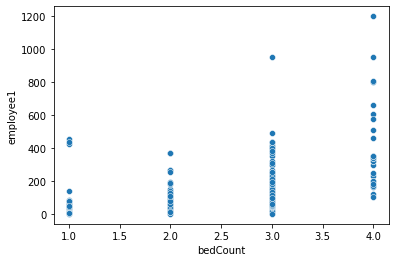

In [420]:
sns.scatterplot(data=train_df, x='bedCount', y='employee1')

<AxesSubplot:xlabel='bedCount', ylabel='employee1'>

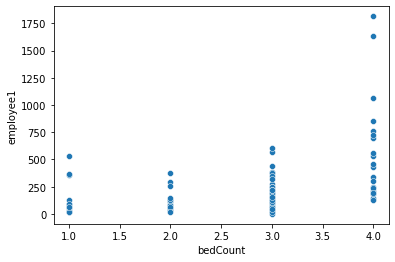

In [421]:
sns.scatterplot(data=test_df, x='bedCount', y='employee1')

#### cf) 결측치 많은 행은 삭제한 뒤에 imputation? 

In [ ]:
# # 행 제거

# train_df = train_df.drop([258,  60,  32, 257,  55,   1, 248,  14, 298,  48, 212, 285, 242, 
#                           93, 263,  62, 299, 206, 193,  35,  71, 300, 230, 297, 217, 220, 
#                           194, 195, 196, 197], axis=0)
# test_df = test_df.drop([15, 56], axis=0)

# 4. Oversampling 

In [422]:
X_train = train_df.drop(['OC'], axis=1)
y_train = train_df.OC

In [373]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

print('before oversampling')
print('train feature set:', X_train.shape, 'train label set:', y_train.shape, '\n')

print('after oversampling')
print('train feature set:', X_train_over.shape, 'train label set:', y_train_over.shape, '\n')
print('Distribution of labels :\n',pd.Series(y_train_over).value_counts() )

before oversampling
train feature set: (301, 54) train label set: (301,) 

after oversampling
train feature set: (572, 54) train label set: (572,) 

Distribution of labels :
 0    286
1    286
Name: OC, dtype: int64


# 5. Feature Scaling

### 5.1.1 Training data의 이상치 확인

In [354]:
non_numerics = set(['inst_id', 'OC', 'sgg', 'openDate', 'bedCount', 'instkind', 'ownerChange', 'Year', 'Month', 'Metro'])
numerics = set(X_train_over.columns).difference(non_numerics)
len(numerics)

46

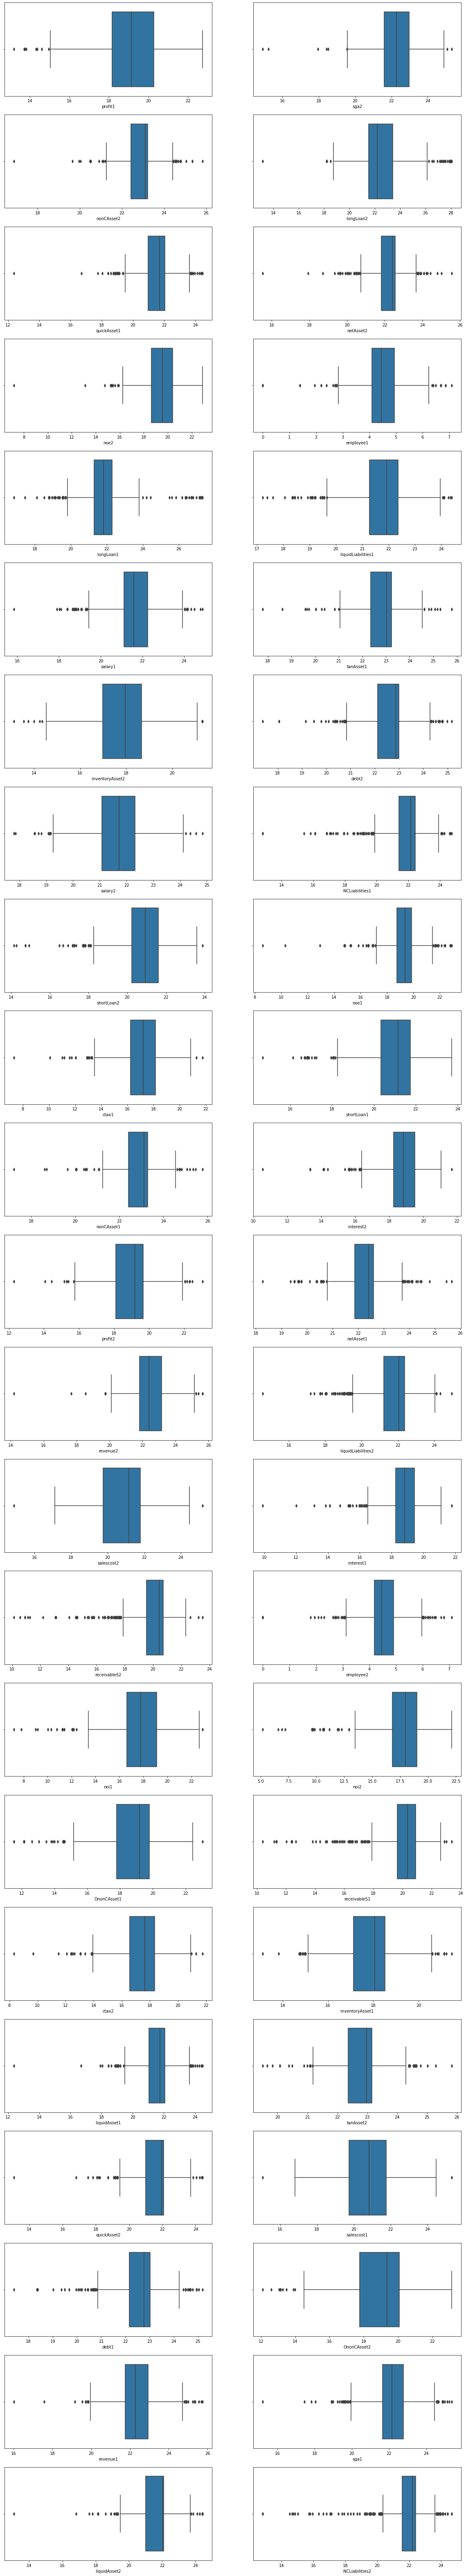

In [355]:
col_n = 2
row_n = 23

fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(20,row_n*5))

for i, col in enumerate(numerics):
    sns.boxplot(data=np.log(X_train_over.loc[:, numerics]), x=col, ax=ax[int(i/col_n),int(i%col_n)])

### 5.1.2 Test data의 이상치 확인

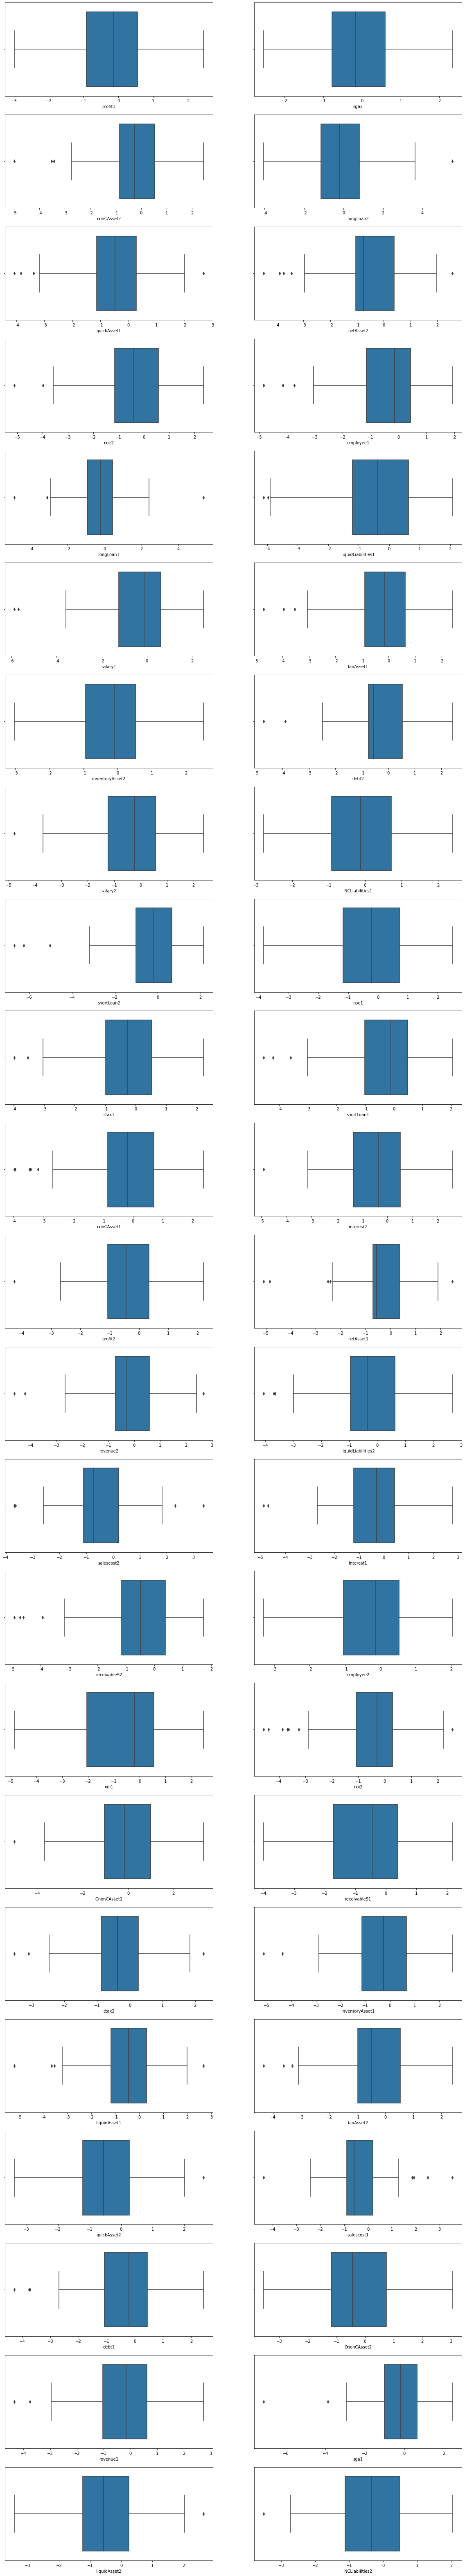

In [360]:
col_n = 2
row_n = 23

fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(20,row_n*5))

for i, col in enumerate(numerics):
    sns.boxplot(data=np.log(test_df.loc[:, numerics]), x=col, ax=ax[int(i/col_n),int(i%col_n)])

**결론: 이상치가 존재하므로 RobustScaler를 사용해 스케일링하기**

In [423]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
train_robust = scaler.fit_transform(X_train_over.loc[:, numerics])
test_robust = scaler.transform(test_df.loc[:, numerics])

train_robust = pd.DataFrame(train_robust, columns = numerics)
test_robust = pd.DataFrame(test_robust, columns = numerics)

for col in train_robust.columns:
    X_train_over[col] = train_robust[col]
    test_df[col] = test_robust[col]

In [424]:
cate = ['inst_id', 'sgg', 'bedCount', 'instkind', 'ownerChange', 'Year', 'Month', 'Metro']

for column in cate:
    X_train[column] = X_train_over[column].astype('category')
    test_df[column] = test_df[column].astype('category')

# 중간 점검 

In [425]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=0)

X_train.shape, y_train.shape
X_val.shape, y_val.shape

((121, 54), (121,))

In [66]:
pip install dmba

Note: you may need to restart the kernel to use updated packages.


In [426]:
from sklearn.tree import DecisionTreeClassifier
from dmba import plotDecisionTree, classificationSummary
import pydotplus

ClassTree = DecisionTreeClassifier(min_samples_leaf=50, max_depth=7)
ClassTree.fit(X_train, y_train)
classificationSummary(y_train, ClassTree.predict(X_train))
classificationSummary(y_val, ClassTree.predict(X_val))

Confusion Matrix (Accuracy 0.9500)

       Prediction
Actual   0   1
     0   0   9
     1   0 171
Confusion Matrix (Accuracy 0.9504)

       Prediction
Actual   0   1
     0   0   6
     1   0 115


In [427]:
scores = cross_val_score(ClassTree, X_train, y_train, cv=5)
scores

array([0.97222222, 0.94444444, 0.94444444, 0.94444444, 0.94444444])

In [431]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_val)
print("Number of mislabeled points out of a total %d points : %d" % (X_val.shape[0], (y_val != y_pred).sum()))

Number of mislabeled points out of a total 121 points : 90


In [428]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_val, y_val))

0.9777777777777777
0.8677685950413223


# 남은 과제  
1. 오버샘플링할 때 결측치 발생하는 점, 오버샘플링한 데이터셋에 대해서는 모델 작동 안하는 점 해결하기  
2. 변수 수 줄이기
    + 17년, 16년 동일 변수끼리 분포 비교해보고 2개년 정보 모두 포함하는 열 만들어보기
    + 정보 중복되는 두 변수 중 취사선택 시) Information Gain 구해보고 판단하기
    + 주요 재무정보 열 만들기
+α) 결측치 처리 방법 바꿔보기(datawig 찾아보기), 다른 모델 적용해보기, 정밀도, 재현율 등 평가지표 살펴보기